# Clasificación de imágenes mediante redes neuronales convolucionales (CNN)
**Objetivo:**

El objetivo de este ejercicio es brindarles a los estudiantes experiencia práctica en la construcción, entrenamiento y evaluación de una red neuronal convolucional (CNN) para la clasificación de imágenes utilizando el conjunto de datos Caltech101. Los estudiantes aprenderán los principios de las CNN, incluidas las capas convolucionales, las capas de agrupación y las capas completamente conectadas, así como las técnicas para la ampliación de datos y la evaluación de modelos.

**Conjunto de datos:**

Caltech101: este conjunto de datos contiene 101 categorías de objetos, con aproximadamente entre 40 y 800 imágenes por categoría. Las imágenes son de varios tamaños, pero la mayoría son de resolución media.

1. **Preparación del conjunto de datos:**

* Descargue el conjunto de datos de Caltech101 y organícelo en conjuntos de
prueba y entrenamiento.

* Aplique técnicas de preprocesamiento de datos, como redimensionar imágenes a un tamaño consistente, normalizar valores de píxeles y aumentar los datos (rotación, escalado, volteo, etc.).

In [1]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

**2. Carga de datos:**

* tfds.load: esta función carga el conjunto de datos especificado. Aquí, se carga el conjunto de datos 'caltech101' con la versión '3.0.1'.

* split=['train[:80%]','train[:20%]']: el conjunto de datos se divide en dos partes: 80% para entrenamiento y 20% para pruebas.

* with_info=True: este indicador indica que se deben devolver metadatos adicionales sobre el conjunto de datos, como la cantidad de clases.

* as_supervised=True: esto garantiza que los datos se devuelvan como una tupla (imagen, etiqueta) en lugar de un diccionario. Este formato es típico para las tareas de aprendizaje supervisado.

* download=False: esto evita que el código descargue el conjunto de datos si aún no está disponible localmente.

In [2]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]', 'test[20%:]'],
    with_info=True,
    as_supervised=True,
    data_dir='data',
    download=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling data/caltech101/incomplete.GXV6BV_3.0.2/caltech101-train.tfrecord*...:   0%|          | 0/3060 [00:0…

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling data/caltech101/incomplete.GXV6BV_3.0.2/caltech101-test.tfrecord*...:   0%|          | 0/6084 [00:00…

Dataset caltech101 downloaded and prepared to data/caltech101/3.0.2. Subsequent calls will reuse this data.


**3. Preprocesamiento de datos:**

* tf.image.resize(image, (224, 224)): cambia el tamaño de cada imagen a 224 x 224 píxeles. Este es un tamaño común para las entradas de CNN, como las que se utilizan en modelos como VGG y ResNet.

* tf.cast(image, tf.float32) / 255.0: convierte los valores de los píxeles a float32 y los normaliza al rango [0, 1]. Esta normalización ayuda a mejorar la convergencia de las redes neuronales durante el entrenamiento.

In [3]:
num_classes = dataset_info.features['label'].num_classes

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

4. **Model definition:**

* models.Sequential: This specifies a linear stack of layers. The layers are added sequentially, meaning each layer has exactly one input tensor and one output tensor.

* layers.Conv2D(32, (3, 3), activation='relu'): This layer creates 32 filters, each of size 3x3, which convolve over the input image. The activation function used is ReLU (Rectified Linear Unit), which introduces non-linearity into the model. input_shape=(224, 224, 3): Specifies the input shape, where 224x224 is the image size and 3 is the number of color channels (RGB).

* layers.MaxPooling2D((2, 2)): This layer performs max pooling with a 2x2 filter, reducing the spatial dimensions (height and width) by half. It helps in reducing the computational complexity and the risk of overfitting by down-sampling the input.

* layers.Conv2D(64, (3, 3), activation='relu'): This layer increases the number of filters to 64, with each filter of size 3x3. This deeper layer can learn more complex features.

* layers.Flatten(): This layer flattens the 2D outputs from the previous layer into a 1D vector, preparing the data for the fully connected layers.

* layers.Dense(128, activation='relu'): A dense layer with 128 units and ReLU activation. Dense layers are fully connected, meaning each neuron in the layer receives input from all neurons in the previous layer. This layer helps in learning complex

* layers.Dense(num_classes, activation='softmax'): The output layer with a number of units equal to the number of classes (num_classes). The softmax activation function is used, which outputs a probability distribution over the classes, making it suitable for multi-class classification.

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5. **Model compilation:**

* optimizer='adam': The Adam (Adaptive Moment Estimation) optimizer is used to adjust the model's weights during training. Adam is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adapts the learning rate for each parameter, making the optimization process more efficient and potentially leading to faster convergence.

* loss='sparse_categorical_crossentropy': This loss function is used for multi-class classification problems where the target labels are integers. In this case, the labels are provided as integers (e.g., 0, 1, 2, ...) rather than one-hot encoded vectors. The sparse categorical crossentropy computes the cross-entropy loss between the true labels and the predicted probabilities, which is suitable for multi-class classification tasks.

* metrics=['accuracy']: This specifies that accuracy will be tracked during training and evaluation. Accuracy is a common metric for classification tasks, representing the proportion of correctly predicted samples.

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.0224 - loss: 6.8376 - val_accuracy: 0.0499 - val_loss: 4.4814
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 405s 5s/step - accuracy: 0.1619 - loss: 3.9401 - val_accuracy: 0.2519 - val_loss: 3.7235
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.5981 - loss: 1.7637 - val_accuracy: 0.3275 - val_loss: 3.8288
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 387s 5s/step - accuracy: 0.9287 - loss: 0.3532 - val_accuracy: 0.3411 - val_loss: 4.4953
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.9763 - loss: 0.1251 - val_accuracy: 0.3429 - val_loss: 4.8854
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.9908 - loss: 0.0519 - val_accuracy: 0.3581 - val_loss: 4.7564
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 431s 5s/step - accuracy: 0.9985 - loss: 0.0160 - val_accuracy: 0.3107 - val_loss: 5.5330
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - accuracy: 0.9928 - loss: 0.0520 - val_accuracy: 0.3577 - v

6**. Comprender la compartición de parámetros y los campos receptivos locales:**
* Analizar la cantidad de parámetros que se pueden aprender en cada capa del modelo CNN.


In [6]:
num_params = model.count_params()
print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 23920550


7. **Evaluación e interpretación:**
* Evalúe el rendimiento del modelo en el conjunto de datos de prueba y calcule la precisión.
* Visualice algunas imágenes mal clasificadas y analice las posibles razones de las clasificaciones erróneas.

In [7]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

153/153 ━━━━━━━━━━━━━━━━━━━━ 135s 879ms/step - accuracy: 0.3453 - loss: 5.8532
Accuracy on the test set: 33.92%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1

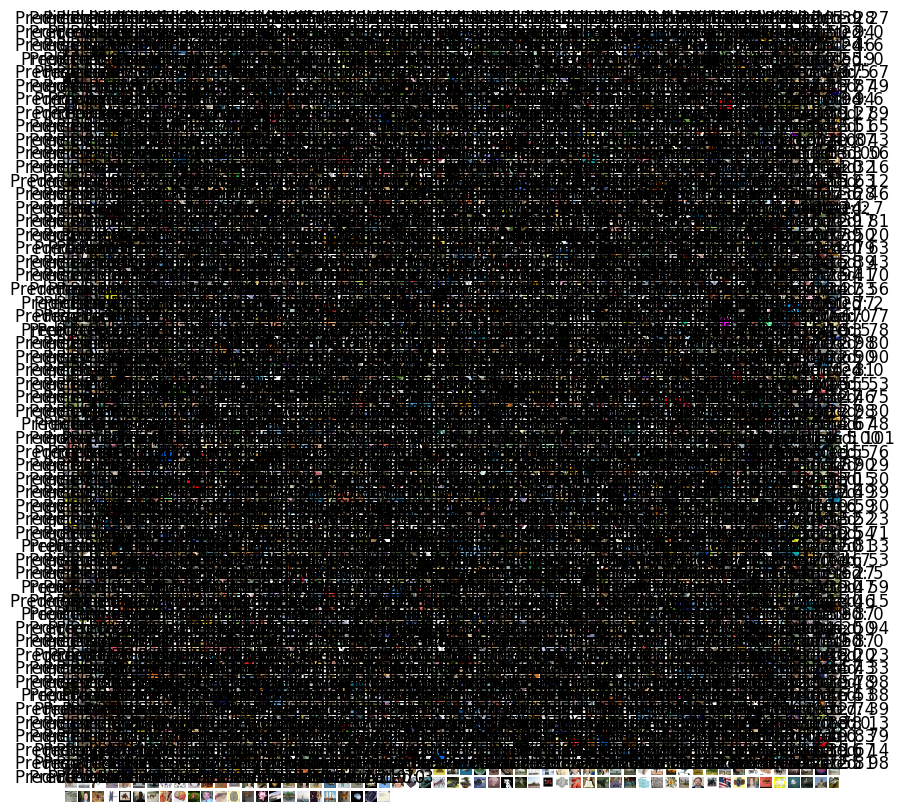

In [8]:
misclassified_images = []
misclassified_labels = []
for image, label in test_dataset:
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    misclassified_idx = np.where(predicted_label != label.numpy())[0]
    for idx in misclassified_idx:
        misclassified_images.append(image[idx])
        misclassified_labels.append(predicted_label[idx])

num_images = len(misclassified_images)
grid_size = int(np.ceil(np.sqrt(num_images)))

plt.figure(figsize=(10, 10))
for i in range(len(misclassified_images)):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(misclassified_images[i])
    plt.title(f"Predicted: {misclassified_labels[i]}")
    plt.axis('off')
plt.show()

8. Elija una imagen de ejemplo y visualice los mapas de características generados por las capas convolucionales.

In [ ]:
niceclassified_images = []
niceclassified_labels = []
for image, label in test_dataset:
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    niceclassified_idx = np.where(predicted_label == label.numpy())[0]
    for idx in niceclassified_idx:
        niceclassified_images.append(image[idx])
        niceclassified_labels.append(predicted_label[idx])

plt.figure(figsize=(30, 30))
for i in range(len(niceclassified_images)):
    plt.subplot(20, 20, i+1)
    plt.imshow(niceclassified_images[i])
    plt.title(f"P: {niceclassified_labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
sample_image, _ = next(itertools.islice(iter(test_dataset), 0, 1))
sample_image = sample_image[:1]

activation_model = models.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# activation_model = models.Model(inputs=model.input, outputs=model.layers[4].output)
activations = activation_model.predict(sample_image)

plt.figure(figsize=(10, 5))
for i, activation in enumerate(activations):
    plt.subplot(2, 4, i+1)
    try:
        plt.imshow(activation[0, :, :, 0], cmap='viridis')
    except:
        pass
    plt.title(f"Activation {i+1}")
    plt.axis('off')
plt.show()